In [171]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Basic Imports

In [172]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [173]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

initial_quantum_state = np.identity(N)[0]

### Simulator Backend

In [174]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### Optimizer

In [175]:
from scipy.optimize import minimize

### Ansatz State

In [176]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [177]:
def get_ansatz_state(thetas, input_state, ansatz_entangelment="full"):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [178]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [179]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [180]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [181]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [182]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [183]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [184]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [185]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [186]:
from qiskit import assemble, transpile
import random

def cost_function(thetas, hamiltonian, initial_eigenvector):    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [187]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, initial_eigenvector):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, initial_eigenvector),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [188]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, initial_eigenvector):    
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, initial_eigenvector)
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [189]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [190]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    
    return min(sorted(eigen_values))

In [191]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(exact_eigenvalue, margin=3)

## Visualization

In [192]:
approximated_energies = []

In [193]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [194]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[-NUM_ITERATIONS:])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## Transverse Ising Model 2 qubits

In [195]:
from qiskit.opflow import X, Z, I

In [196]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

In [197]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, initial_quantum_state)

3it [00:00, 17.81it/s]
3it [00:00, 10.50it/s]
3it [00:00, 17.96it/s]
3it [00:00, 20.16it/s]
3it [00:00, 16.94it/s]
3it [00:00, 13.70it/s]
3it [00:00, 20.41it/s]
3it [00:00, 17.86it/s]
3it [00:00, 11.67it/s]
3it [00:00, 13.09it/s]
3it [00:00, 19.23it/s]
3it [00:00, 19.48it/s]
3it [00:00, 13.62it/s]
3it [00:00, 14.66it/s]
3it [00:00, 17.54it/s]
3it [00:00, 18.42it/s]
3it [00:00, 10.93it/s]
3it [00:00, 18.61it/s]
3it [00:00, 18.84it/s]
3it [00:00, 18.19it/s]
3it [00:00, 12.27it/s]
3it [00:00, 19.23it/s]
3it [00:00, 19.23it/s]
3it [00:00, 13.01it/s]
3it [00:00, 15.00it/s]
3it [00:00, 20.51it/s]
3it [00:00, 15.81it/s]
3it [00:00, 10.57it/s]
3it [00:00, 19.64it/s]
3it [00:00, 19.52it/s]
3it [00:00, 14.70it/s]
3it [00:00, 14.58it/s]
3it [00:00, 18.07it/s]
3it [00:00, 18.91it/s]
3it [00:00, 10.60it/s]
3it [00:00, 19.11it/s]
3it [00:00, 18.81it/s]
3it [00:00, 15.15it/s]
3it [00:00, 17.61it/s]
3it [00:00, 19.55it/s]
3it [00:00, 19.99it/s]
3it [00:00, 11.52it/s]
3it [00:00, 18.05it/s]
3it [00:00,

CPU times: total: 8.62 s
Wall time: 10 s


Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.960049627267689

Approximation Error
0.0651670328723425


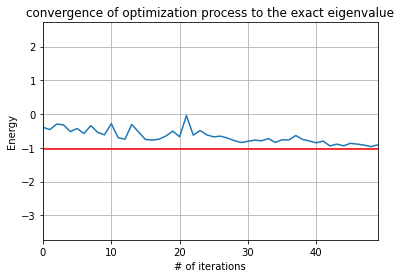

In [198]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [199]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

In [200]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, initial_quantum_state)

4it [00:00, 12.20it/s]
4it [00:00, 18.92it/s]
4it [00:00, 20.12it/s]
4it [00:00, 13.33it/s]
4it [00:00, 19.09it/s]
4it [00:00, 20.30it/s]
4it [00:00, 14.43it/s]
4it [00:00, 18.73it/s]
4it [00:00, 14.73it/s]
4it [00:00, 13.46it/s]
4it [00:00, 20.46it/s]
4it [00:00, 16.10it/s]
4it [00:00, 14.44it/s]
4it [00:00, 19.90it/s]
4it [00:00, 15.67it/s]
4it [00:00, 14.21it/s]
4it [00:00, 16.95it/s]
4it [00:00,  9.78it/s]
4it [00:00, 16.61it/s]
4it [00:00,  9.68it/s]
4it [00:00, 15.69it/s]
4it [00:00, 16.54it/s]
4it [00:00, 16.78it/s]
4it [00:00, 18.83it/s]
4it [00:00, 11.66it/s]
4it [00:00, 18.56it/s]
4it [00:00, 19.15it/s]
4it [00:00, 11.65it/s]
4it [00:00, 19.72it/s]
4it [00:00, 15.46it/s]
4it [00:00, 12.15it/s]
4it [00:00, 17.17it/s]
4it [00:00, 12.63it/s]
4it [00:00, 17.13it/s]
4it [00:00, 19.23it/s]
4it [00:00, 12.52it/s]
4it [00:00, 18.72it/s]
4it [00:00, 20.28it/s]
4it [00:00, 14.72it/s]
4it [00:00, 14.61it/s]
4it [00:00, 17.58it/s]
4it [00:00, 12.85it/s]
4it [00:00, 16.60it/s]
4it [00:00,

CPU times: total: 11.4 s
Wall time: 13.8 s


Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9894879075429033

Approximation Error
0.015539441996006605


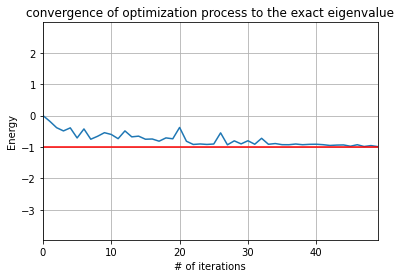

In [201]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)